# Tumor Diagnosis

In this project, we aim to apply data analysis, dimensionality reduction, and clustering techniques to better understand the tumor characteristics and their classification.

### 01. Import libraries

In [1]:
# Data manipulation and analysis
import numpy as np
import pandas as pd
import time
import json
import math

# Modeling
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, \
    classification_report, confusion_matrix
from sklearn.tree import plot_tree

# Visualizations
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Set option to display all columns
pd.set_option('display.max_columns', None)

### 02. Import data

__Class distribution:__
- __diagnosis__: Target column containing the class $labels$
  - $M$ - $Malignant$ $\rightarrow$ Tending to invade normal tissue, indicating a more harmful nature.
  - $B$ - $Benign$ $\rightarrow$ Not harmful, indicating a non-invasive and less concerning form.

__Columns in the dataset:__

0. __id__ Contains unique identifiers for each record. As a unique identifier, it cannot be used for classification purposes.
1. __radius__ Mean of distances from the center to points on the perimeter of the nucleus.
2. __texture__ Standard deviation of the gray-scale values.
3. __perimeter__ Total distance around the boundary of the nucleus.
4. __area__ Total area of the nucleus.
5. __smoothness__ Local variation in radius lengths, indicating the smoothness of the boundary.
6. __compactness__ Indicating how compact the nucleus is. (perimeter^2 / area - 1.0) 
7. __concavity__ Severity of concave portions of the contour, measuring how inward the boundary is.
8. __concave points__ Number of concave portions on the contour of the nucleus.
9. __symmetry__ Measures the symmetry of the nucleus.
10. __fractal dimension__ A measure of the "coastline approximation", calculated as the ratio of the perimeter to area.

In [3]:
# Find principal path of the project
from pathlib import Path
project_root = str(Path.cwd().parents[0])

# Load the column names from the JSON file
with open(project_root + '.\static\column_names.json', 'r') as json_file:
    saved_column_names = json.load(json_file)

# Read the .data file into a Pandas DataFrame
df = pd.read_csv(project_root + '.\static\wdbc.data', header=None, names=saved_column_names)

# Display the first few rows of the DataFrame
df.head()

,id,diagnosis,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,radius2,texture2,perimeter2,area2,smoothness2,compactness2,concavity2,concave_points2,symmetry2,fractal_dimension2,radius3,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
# Beautifully formatted output for dataset details
print(f"Data Points (Rows)   : {df.shape[0]:,}")
print(f"Features (Columns)   : {df.shape[1]}")
print(f"Feature Names        : {', '.join(df.columns)}")

Data Points (Rows)   : 569
Features (Columns)   : 32
Feature Names        : id, diagnosis, radius1, texture1, perimeter1, area1, smoothness1, compactness1, concavity1, concave_points1, symmetry1, fractal_dimension1, radius2, texture2, perimeter2, area2, smoothness2, compactness2, concavity2, concave_points2, symmetry2, fractal_dimension2, radius3, texture3, perimeter3, area3, smoothness3, compactness3, concavity3, concave_points3, symmetry3, fractal_dimension3


### 03. Data preprocesing

In this step, the unique identifier column will be removed from the dataset, as it does not contribute to the classification task. Additionally, we will perform label encoding on the $diagnosis$ column to transform the categorical labels into numerical values, making them suitable for machine learning models.

The LabelEncoder from sklearn.preprocessing will be used to convert the labels in the diagnosis column ('B' for Benign and 'M' for Malignant) to binary values (0 and 1).

In [5]:
# The 'id' column is an arbitrary identifier with no meaningful contribution 
# to pattern analysis, correlations, or clustering, and may introduce noise into the model.
df_cleaned = df.drop(columns=['id'])

In [6]:
# Creating an instance of LabelEncoder to perform label encoding
label_encoder = LabelEncoder()

# Convert 'diagnosis' column from 'b' and 'm' to 0 and 1
df_cleaned['diagnosis'] = label_encoder.fit_transform(df_cleaned['diagnosis'])

In [7]:
# See preprocessing result
df_cleaned.head()

,diagnosis,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,radius2,texture2,perimeter2,area2,smoothness2,compactness2,concavity2,concave_points2,symmetry2,fractal_dimension2,radius3,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


### 04. Correlation Analysis

The purpose of this analysis is to examine the correlation between the features in the dataset. Identifying highly correlated features is important because multicollinearity can negatively impact model performance. However, in this case, we will not remove any features, as we want to evaluate their influence on the performance of PCA (Principal Component Analysis) and clustering in later stages of the analysis.

In [8]:
# Create correlation matrix
corr_matrix = df_cleaned.corr()

In [ ]:
# Create Pairplot from Seaborn to see relationship between individual features and diagnosis
# 'Benign (0)', 'Malignant (1)'
sns.pairplot(df_cleaned, palette='coolwarm', hue='diagnosis')

# Adjust legend position to the upper left corner
plt.legend(title='Diagnosis', loc='upper left', labels=['Benign (0)', 'Malignant (1)'], fontsize=12)

# Show the plot
plt.show()

In [ ]:
# Distribution of Features
plt.figure(figsize=(19, 17))

# Automatically get numerical columns
numerical_features = df_cleaned.select_dtypes(include=['number']).columns

# Number of rows and columns for subplots
rows = math.ceil(len(df_cleaned.columns) / 3)
cols = 3

# Adjust the figure size
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 15))

# Flatten the axis array for easy access
ax = ax.flatten()

# Iterate over the numerical features
for i in range(len(numerical_features)):
    sns.histplot(df_cleaned[numerical_features[i]], color='crimson', kde=True, ax=ax[i])
    ax[i].set_title(f'Distribution: {numerical_features[i]}')

# Remove unused subplots if there are fewer features
for j in range(i + 1, rows * cols):
    fig.delaxes(ax[j])

plt.tight_layout()
plt.show()

In [ ]:
# Plot the correlation matrix
plt.figure(figsize=(19, 17))
sns.heatmap(corr_matrix, xticklabels=corr_matrix.columns, yticklabels=corr_matrix.columns, annot=True, annot_kws={"size": 8}, fmt=".2f")
plt.show()

In [9]:
# Mask the diagonal (set to NaN) to avoid self-correlation
np.fill_diagonal(corr_matrix.values, np.nan)

# Stack the correlation matrix and sort the values
corr_pairs = corr_matrix.unstack().sort_values(ascending=False)

# Show the pairs with the highest correlation, excluding the diagonal
corr_pairs.head(10)

radius1     perimeter1    0.997855
perimeter1  radius1       0.997855
radius3     perimeter3    0.993708
perimeter3  radius3       0.993708
radius1     area1         0.987357
area1       radius1       0.987357
perimeter1  area1         0.986507
area1       perimeter1    0.986507
radius3     area3         0.984015
area3       radius3       0.984015
dtype: float64

### 05. Decision Tree

Decision Trees are a supervised classification and regression algorithm that splits the dataset into subsets based on feature values. It recursively partitions the data, creating a tree-like structure where each internal node represents a feature test, each branch represents the outcome of the test, and each leaf node represents a predicted class or value.

- __Input Features:__ Decision trees work well with both numerical and categorical features. The model recursively splits the data based on feature values to create the tree structure. The most informative features (based on some splitting criterion) are used at the top of the tree.

- __Splitting Criterion:__ Decision trees use criteria such as Gini impurity or Entropy (for classification) to evaluate how well a feature splits the data. A split is made when it minimizes impurity in the child nodes.

    - Gini Impurity: Measures the likelihood of incorrect classification of a new instance.
    
    $$Gini = 1 - \sum_{i=1}^{C} p_i^2$$

    > where $p_i$ is the probability of class $i$ in the current node.


    - Entropy: Measures the amount of uncertainty or disorder in the data.
    
    $$Entropy = - \sum_{i=1}^{C} p_i\log_2(p_i)$$

    > where $p_i$ is the probability of class $i$ in the current node.


- __Thresholding:__ Once the model outputs probabilities, a threshold (commonly 0.5) is applied to classify observations into one of the two categories.


Combining Trees with Other Models:
If you plan to compare decision trees with models like Logistic Regression, SVMs, or Gradient Descent-based models, standardizing ensures that all models work on similarly scaled data.

In [10]:
# Features and target
X = df_cleaned.iloc[:, 1:]  # Features (skip diagnosis)
y = df_cleaned['diagnosis']  # Target

In [11]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

The baseline establishes an initial performance level that serves as a minimum standard for comparing more complex models.

In [12]:
# Initialize the model with default parameters
dt_baseline = DecisionTreeClassifier(random_state=42)

# Train the model
dt_baseline.fit(X_train, y_train)

# Predictions
y_pred = dt_baseline.predict(X_test)
y_pred_prob = dt_baseline.predict_proba(X_test)[:, 1]  # Probabilities for ROC-AUC

# Calculate Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Print Metrics
print("Baseline Decision Tree Performance:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC-AUC: {roc_auc:.2f}")

Baseline Decision Tree Performance:
Accuracy: 0.90
Precision: 0.89
Recall: 0.84
F1 Score: 0.86
ROC-AUC: 0.89


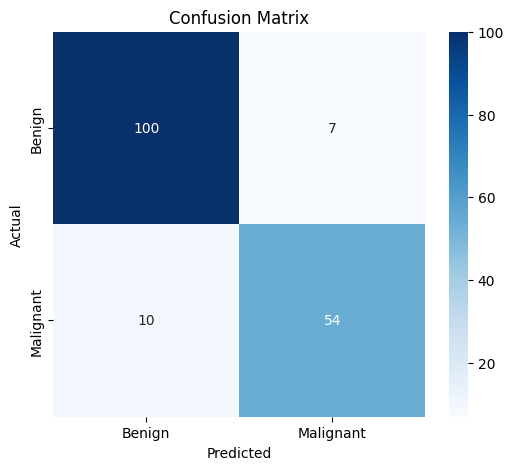

In [13]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Benign", "Malignant"], yticklabels=["Benign", "Malignant"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [14]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       107
           1       0.89      0.84      0.86        64

    accuracy                           0.90       171
   macro avg       0.90      0.89      0.89       171
weighted avg       0.90      0.90      0.90       171



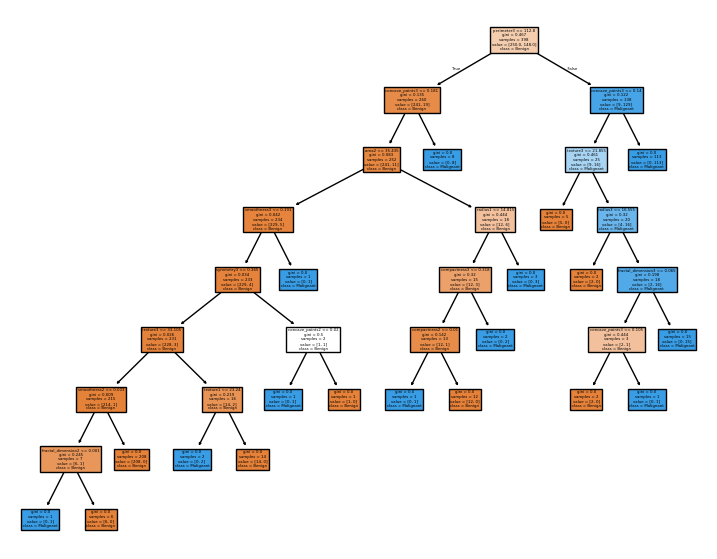

In [15]:
# Visualize the tree
plt.figure(figsize=(9, 7))
plot_tree(dt_baseline, feature_names=X.columns, class_names=["Benign", "Malignant"], filled=True)
plt.show()

### 06. Evaluate the Tuned Model

In [16]:
# Define hyperparameters to tune
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy'],
    'max_features': [None, 'sqrt', 'log2']
}

# Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Hyperparameters:", best_params)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Hyperparameters: {'criterion': 'gini', 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 10}


In [17]:
# Evaluate the best model
y_pred = best_model.predict(X_test)
y_pred_prob = best_model.predict_proba(X_test)[:, 1]  # Probability for the positive class

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Print metrics
print("Evaluation Metrics for Tuned Decision Tree:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC-AUC: {roc_auc:.2f}")

Evaluation Metrics for Tuned Decision Tree:
Accuracy: 0.92
Precision: 1.00
Recall: 0.78
F1 Score: 0.88
ROC-AUC: 0.92


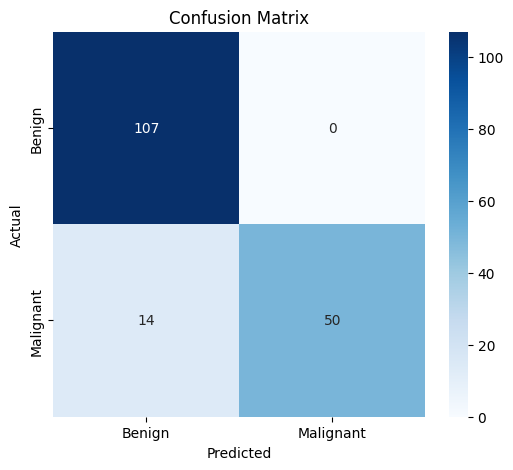

In [18]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Benign", "Malignant"], yticklabels=["Benign", "Malignant"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [19]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.88      1.00      0.94       107
           1       1.00      0.78      0.88        64

    accuracy                           0.92       171
   macro avg       0.94      0.89      0.91       171
weighted avg       0.93      0.92      0.92       171



### 07. Model evaluation and interpretation

__Conclusion__

The tuned Decision Tree model has a higher accuracy (92%) compared to the baseline model (90%) and a perfect precision for the malignant class. However, it sacrifices recall for malignant cases (down to 78% from 84%), which means it misses more true positives. Despite this, the overall performance metrics (F1 score and ROC-AUC) are still strong, making the tuned model a good improvement for certain use cases, especially where precision for malignant cases is critical.

### 08. Model Competition

In this step, we evaluate to see which one performs best based on various metrics.

In [20]:
import warnings
warnings.filterwarnings("ignore")

Decision Tree:
  Accuracy: 0.92
  Precision: 1.00
  Recall: 0.78
  F1 Score: 0.88
  ROC-AUC: 0.92

Random Forest:
  Accuracy: 0.96
  Precision: 1.00
  Recall: 0.91
  F1 Score: 0.95
  ROC-AUC: 1.00

Gradient Boosting:
  Accuracy: 0.96
  Precision: 1.00
  Recall: 0.91
  F1 Score: 0.95
  ROC-AUC: 1.00

Logistic Regression:
  Accuracy: 0.94
  Precision: 0.98
  Recall: 0.86
  F1 Score: 0.92
  ROC-AUC: 0.99



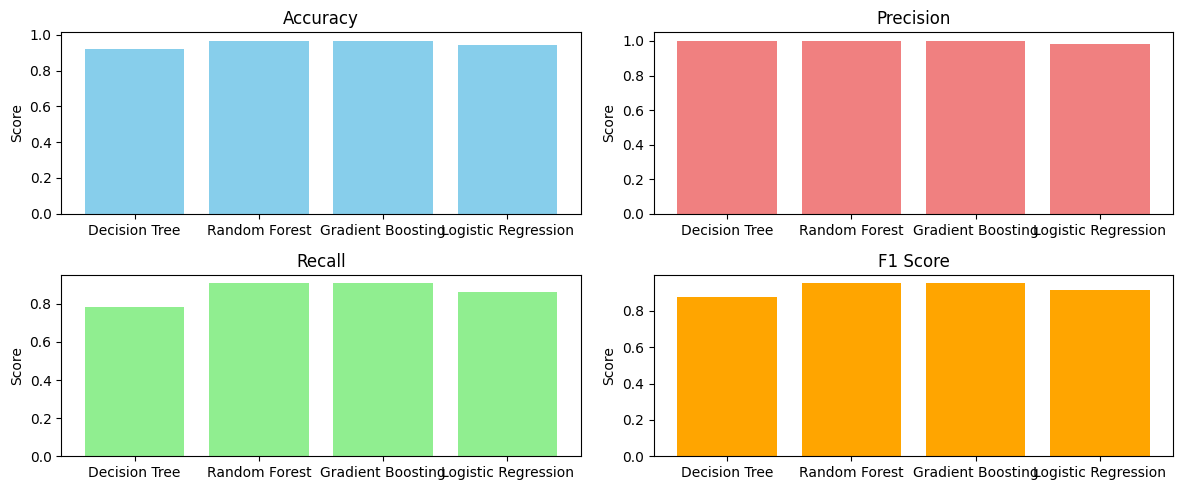

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Define models
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42, **best_params),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42)
}

# Train and evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]  # Get probabilities for ROC-AUC
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_prob)

    # Store results
    results[name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "ROC-AUC": roc_auc
    }

    # Print results
    print(f"{name}:")
    print(f"  Accuracy: {accuracy:.2f}")
    print(f"  Precision: {precision:.2f}")
    print(f"  Recall: {recall:.2f}")
    print(f"  F1 Score: {f1:.2f}")
    print(f"  ROC-AUC: {roc_auc:.2f}")
    print()

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results).T

# Plot results for Accuracy, Precision, Recall, F1, and ROC-AUC
fig, axes = plt.subplots(2, 2, figsize=(12, 5))

# Plot Accuracy
axes[0, 0].bar(results_df.index, results_df['Accuracy'], color='skyblue')
axes[0, 0].set_title('Accuracy')
axes[0, 0].set_ylabel('Score')

# Plot Precision
axes[0, 1].bar(results_df.index, results_df['Precision'], color='lightcoral')
axes[0, 1].set_title('Precision')
axes[0, 1].set_ylabel('Score')

# Plot Recall
axes[1, 0].bar(results_df.index, results_df['Recall'], color='lightgreen')
axes[1, 0].set_title('Recall')
axes[1, 0].set_ylabel('Score')

# Plot F1 Score
axes[1, 1].bar(results_df.index, results_df['F1 Score'], color='orange')
axes[1, 1].set_title('F1 Score')
axes[1, 1].set_ylabel('Score')

# Adjust layout
plt.tight_layout()
plt.show()

### End